In [2]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/dataset_citra_tebu/datatebu')

Mounted at /content/drive


In [3]:
!pip install tensorflow

In [4]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import cv2
import os
from skimage.feature import graycomatrix, graycoprops
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [5]:
tebu_healthy = glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/train/healthy/*.JPG') + \
             glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/test/healthy/*.JPG')
tebu_rust = glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/train/rust/*.JPG') + \
            glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/test/rust/*.JPG')
tebu_redrot = glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/train/redrot/*.JPG') + \
              glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/test/redrot/*.JPG')
tebu_yellow= glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/train/yellow/*.JPG') + \
             glob('/content/drive/My Drive/dataset_citra_tebu/datatebu/test/yellow/*.JPG')

In [6]:
# Gabungkan semua path gambar
all_images = tebu_healthy + tebu_redrot + tebu_rust + tebu_yellow
# healthy = 0, redrot = 1, rust = 2, yellow = 3
labels = (
    [0] * len(tebu_healthy) +
    [1] * len(tebu_redrot) +
    [2] * len(tebu_rust) +
    [3] * len(tebu_yellow)
)


In [7]:
print("Jumlah citra per kelas:")
print(f"Healthy : {len(tebu_healthy)}")
print(f"Redrot  : {len(tebu_redrot)}")
print(f"Rust    : {len(tebu_rust)}")
print(f"Yellow  : {len(tebu_yellow)}")


Jumlah citra per kelas:
Healthy : 279
Redrot  : 278
Rust    : 277
Yellow  : 238


## Pre processing

In [8]:
# 2. Fungsi preprocessing
def preprocess_image(image_path, size=(256, 256)):
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error membaca gambar: {image_path}")
        return None
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #cv ke grayscale
    img_resized = cv2.resize(img_gray, size) #Resize image
    img_blur = cv2.GaussianBlur(img_resized, (5, 5), 0) #Tambahkan noise
    img_normalized = img_blur / 255.0
    return img_normalized

# 3. Buat folder output
output_dir = "/content/preprocessed_tebu3"
os.makedirs(output_dir, exist_ok=True)

# 4. Proses & simpan citra sehat
for i, image_path in enumerate(tebu_healthy):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_healthy_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

# 5. Proses & simpan citra berpenyakit
for i, image_path in enumerate(tebu_rust):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_rust_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

for i, image_path in enumerate(tebu_yellow):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_yellow_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))


for i, image_path in enumerate(tebu_redrot):
    processed_image = preprocess_image(image_path)
    if processed_image is not None:
        output_path = os.path.join(output_dir, f"tebu_redrot_{i}.png")
        cv2.imwrite(output_path, (processed_image * 255).astype(np.uint8))

print("Preprocessing selesai! Semua gambar telah disimpan.")


Preprocessing selesai! Semua gambar telah disimpan.


## Augmentasi

In [9]:
import os
import glob
import cv2
import numpy as np

# Fungsi augmentasi gambar grayscale
def augment_image(image_path, augment=True):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    augmented_images = [img]  # Gambar asli

    if augment:
        # Flip horizontal
        img_flip = cv2.flip(img, 1)
        augmented_images.append(img_flip)

        # Rotasi 15 derajat
        h, w = img.shape
        M = cv2.getRotationMatrix2D((w//2, h//2), 15, 1)
        img_rotated = cv2.warpAffine(img, M, (w, h))
        augmented_images.append(img_rotated)

        # Tambah Gaussian noise
        noise = np.random.normal(0, 25, img.shape).astype(np.uint8)
        img_noisy = cv2.add(img, noise)
        augmented_images.append(img_noisy)

    return augmented_images

# Path input dari gambar hasil preprocessing
preprocessed_dir = "/content/preprocessed_tebu3"
image_paths = glob.glob(os.path.join(preprocessed_dir, "*.png"))

# Path untuk simpan hasil augmentasi
augmented_dir = "/content/augmented_tebu3"
os.makedirs(augmented_dir, exist_ok=True)

# Lakukan augmentasi dan simpan
for i, path in enumerate(image_paths):
    basename = os.path.basename(path).lower()

    # Tentukan label berdasarkan nama file
    if "healthy" in basename:
        label = "healthy"
    elif "redrot" in basename:
        label = "redrot"
    elif "yellow" in basename:
        label = "yellow"
    elif "rust" in basename:
        label = "rust"
    else:
        label = "unknown"

    # Lakukan augmentasi
    augmented_images = augment_image(path)

    # Simpan semua gambar hasil augmentasi
    for j, img in enumerate(augmented_images):
        img = img.astype(np.float32) / 255.0  # Normalisasi
        output_path = os.path.join(augmented_dir, f"augmented_{label}_{i}_{j}.png")
        cv2.imwrite(output_path, (img * 255).astype(np.uint8))

print("Augmented images with labels saved successfully!")


Augmented images with labels saved successfully!


### Simpan hasil

In [10]:
import shutil

# 1. Zip folder hasil preprocessing
preprocessed_folder = '/content/preprocessed_tebu3'
shutil.make_archive(preprocessed_folder, 'zip', preprocessed_folder)

# 2. Zip folder hasil augmentasi
augmented_folder = '/content/augmented_tebu3'
shutil.make_archive(augmented_folder, 'zip', augmented_folder)

print("Kedua folder berhasil dijadikan ZIP!")


Kedua folder berhasil dijadikan ZIP!


## Save file augmentasi

In [11]:
import os
import shutil
import random
from glob import glob

# Lokasi folder awal
augmented_dir = '/content/augmented_tebu3'

# Struktur baru
base_dir = '/content/augmented_tebu3_structured'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
labels = ['healthy', 'redrot', 'rust', 'yellow']

# Buat struktur folder
for split in ['train', 'test']:
    for label in labels:
        os.makedirs(os.path.join(base_dir, split, label), exist_ok=True)

# Ambil semua gambar berdasarkan label
for label in labels:
    images = glob(os.path.join(augmented_dir, f'*{label}*.png'))
    random.shuffle(images)

    # Split 80% train dan 20% test
    split_idx = int(0.8 * len(images))
    train_images = images[:split_idx]
    test_images = images[split_idx:]

    for img in train_images:
        dst = os.path.join(train_dir, label, os.path.basename(img))
        shutil.copy(img, dst)

    for img in test_images:
        dst = os.path.join(test_dir, label, os.path.basename(img))
        shutil.copy(img, dst)

print("Struktur dataset berhasil disusun!")


Struktur dataset berhasil disusun!


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image Generator
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'train'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    color_mode='rgb'
)

val_generator = datagen.flow_from_directory(
    directory=os.path.join(base_dir, 'test'),
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False,
    color_mode='rgb'
)


Found 3428 images belonging to 4 classes.
Found 860 images belonging to 4 classes.


## Modelling

In [13]:
# Load ResNet50 tanpa top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze layer dari base model
for layer in base_model.layers:
    layer.trainable = False

# Tambahkan custom top layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)  # 4 kelas

# Final model
model = Model(inputs=base_model.input, outputs=predictions)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [15]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 41s 242ms/step - accuracy: 0.2592 - loss: 1.3927 - val_accuracy: 0.2581 - val_loss: 1.3916
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - accuracy: 0.2726 - loss: 1.3841 - val_accuracy: 0.2581 - val_loss: 1.3782
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 109ms/step - accuracy: 0.2837 - loss: 1.3763 - val_accuracy: 0.2616 - val_loss: 1.3703
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 129ms/step - accuracy: 0.3068 - loss: 1.3741 - val_accuracy: 0.3244 - val_loss: 1.3651
Epoch 5/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - accuracy: 0.3250 - loss: 1.3689 - val_accuracy: 0.2674 - val_loss: 1.3644
Epoch 6/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 112ms/step - accuracy: 0.3084 - loss: 1.3635 - val_accuracy: 0.2570 - val_loss: 1.3713
Epoch 7/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 14s 134ms/step - accuracy: 0.3033 - loss: 1.3668 - val_accuracy: 0.3058 - val_loss: 1.3600
Epoch 8/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.3476 - loss: 1

In [16]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from skimage.measure import shannon_entropy

# Fungsi ekstraksi fitur GLCM dari citra grayscale
def extract_glcm_features(img, distances=[1], angles=[0], levels=256):
    glcm = graycomatrix(img, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'ASM': graycoprops(glcm, 'ASM')[0, 0],
        'mean': np.mean(img),
        'median': np.median(img),
        'entropy': shannon_entropy(img)
    }
    return features

# Folder citra hasil augmentasi
augmented_dir = '/content/augmented_tebu3'
image_paths = glob.glob(os.path.join(augmented_dir, '*.png'))

# List untuk simpan hasil
data = []

for path in image_paths:
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    features = extract_glcm_features(img)
# healthy = 0, redrot = 1, rust = 2, yellow = 3
    # Ambil label dari nama file
    basename = os.path.basename(path).lower()
    if 'healthy' in basename:
        label = 0
    elif 'redrot' in basename:
        label = 1
    elif 'rust' in basename:
        label = 2
    elif 'yellow' in basename:
        label = 3
    else:
        label = -1  # unknown

    features['label'] = label
    features['filename'] = os.path.basename(path)
    data.append(features)

# Simpan ke DataFrame
df = pd.DataFrame(data)

# Simpan ke CSV
csv_path = '/content/glcm_tebu.csv'
df.to_csv(csv_path, index=False)
print(f"Fitur GLCM berhasil disimpan ke: {csv_path}")


Fitur GLCM berhasil disimpan ke: /content/glcm_tebu.csv


In [17]:
# Tambahan 1 & 2 sudah ada dalam kode kamu, tapi akan diperbaiki dan disusun agar rapi dan efektif.
# Kita akan:
# ✅ Gunakan StandardScaler (sudah ada)
# ✅ Gunakan GridSearchCV untuk hyperparameter tuning (n_neighbors, weights, p)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd

# 1. Load CSV hasil ekstraksi fitur GLCM
# Ensure this path is correct and the CSV file exists
df = pd.read_csv('/content/glcm_tebu.csv')

# 2. Pisahkan fitur dan label
X = df.drop(columns=['label', 'filename'])  # Hapus kolom yang bukan fitur
y = df['label']  # Label: 0 = Healthy, 1 = redrot, 2 = rust, 3 = yellow

# 3. Split data latih dan uji
# Define X_train and y_train before using them in grid.fit
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Pipeline untuk scaling + KNN
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# 5. Parameter grid untuk GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 21)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [2]  # p=1: Manhattan, p=2: Euclidean
}

# 6. GridSearch dengan 5-fold cross-validation
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

# 7. Hasil terbaik
print("Best Parameters:", grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.4f}")

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Parameters: {'knn__n_neighbors': 8, 'knn__p': 2, 'knn__weights': 'distance'}
Best CV Accuracy: 0.6082


## Visualisasi

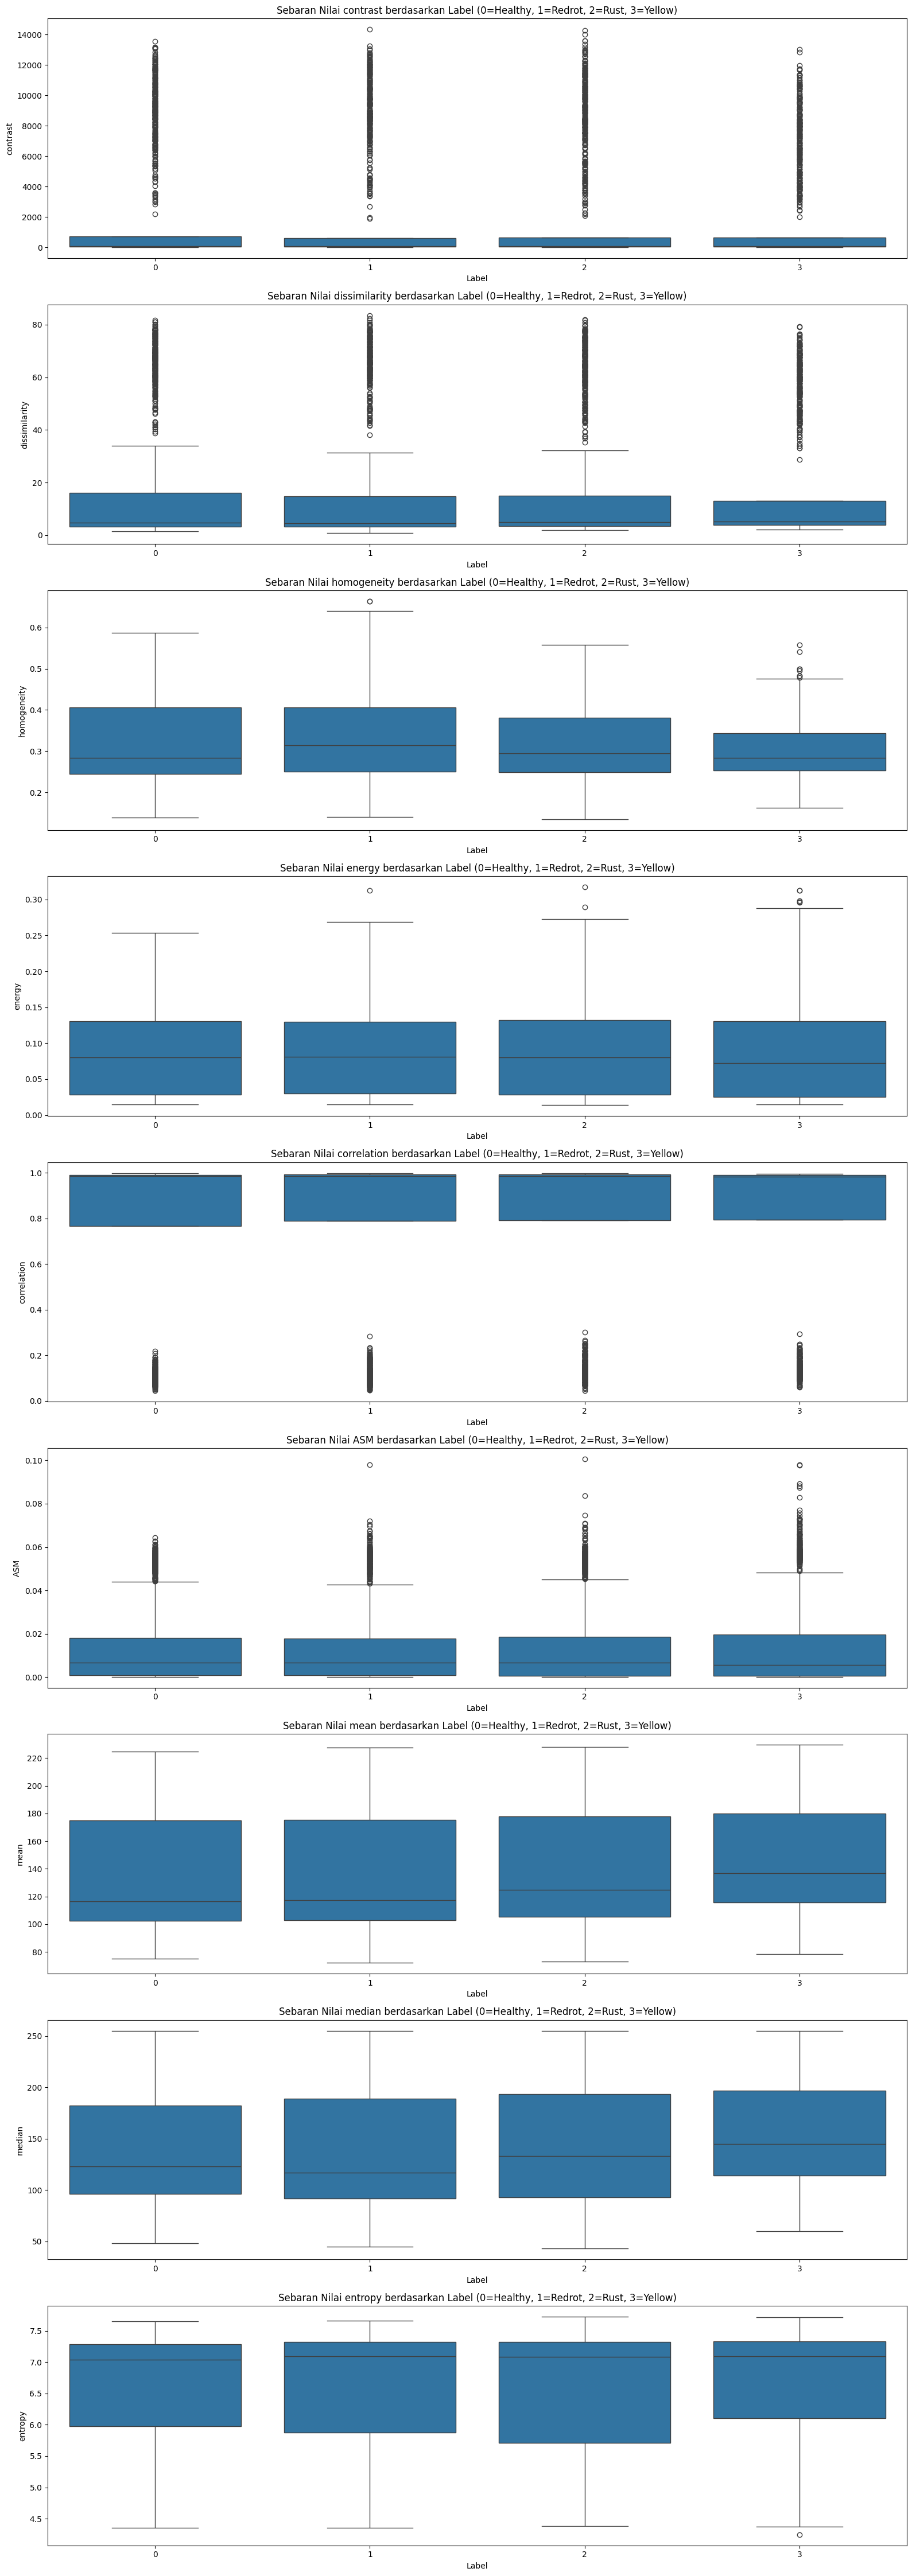

In [18]:
# Ambil semua fitur GLCM (kecuali label dan filename)
glcm_features = df.drop(columns=['label', 'filename']).columns

# Ukuran plot
plt.figure(figsize=(16, len(glcm_features) * 5))

# Loop fitur
for i, feature in enumerate(glcm_features, 1):
    plt.subplot(len(glcm_features), 1, i)
    sns.boxplot(x='label', y=feature, data=df)
    plt.title(f'Sebaran Nilai {feature} berdasarkan Label (0=Healthy, 1=Redrot, 2=Rust, 3=Yellow)')
    plt.xlabel('Label')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


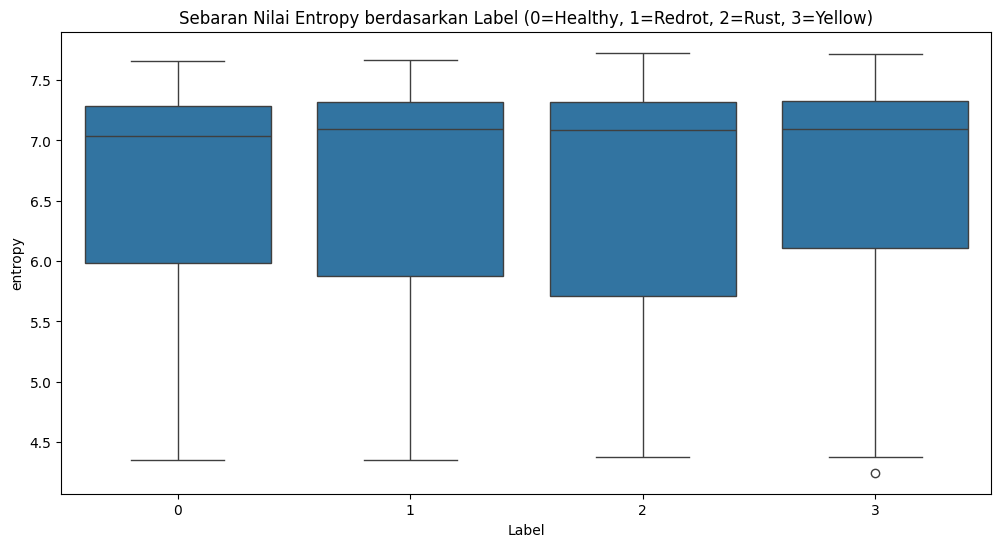

In [19]:
# Visualisasi sebaran fitur GLCM contrast
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='entropy', data=df)
plt.title('Sebaran Nilai Entropy berdasarkan Label (0=Healthy, 1=Redrot, 2=Rust, 3=Yellow)')
plt.xlabel('Label')
plt.show()


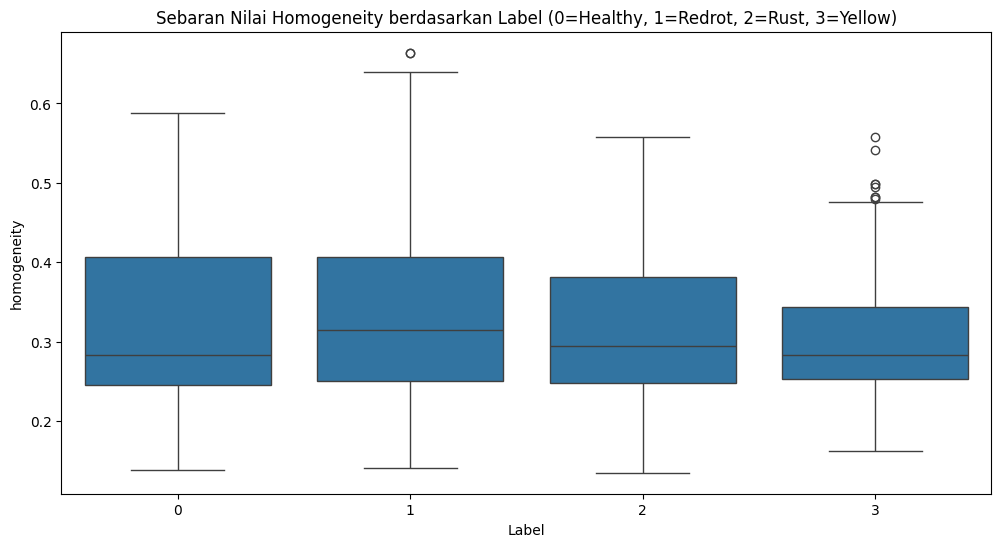

In [20]:
# Visualisasi sebaran fitur GLCM contrast
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='homogeneity', data=df)
plt.title('Sebaran Nilai Homogeneity berdasarkan Label (0=Healthy, 1=Redrot, 2=Rust, 3=Yellow)')
plt.xlabel('Label')
plt.show()


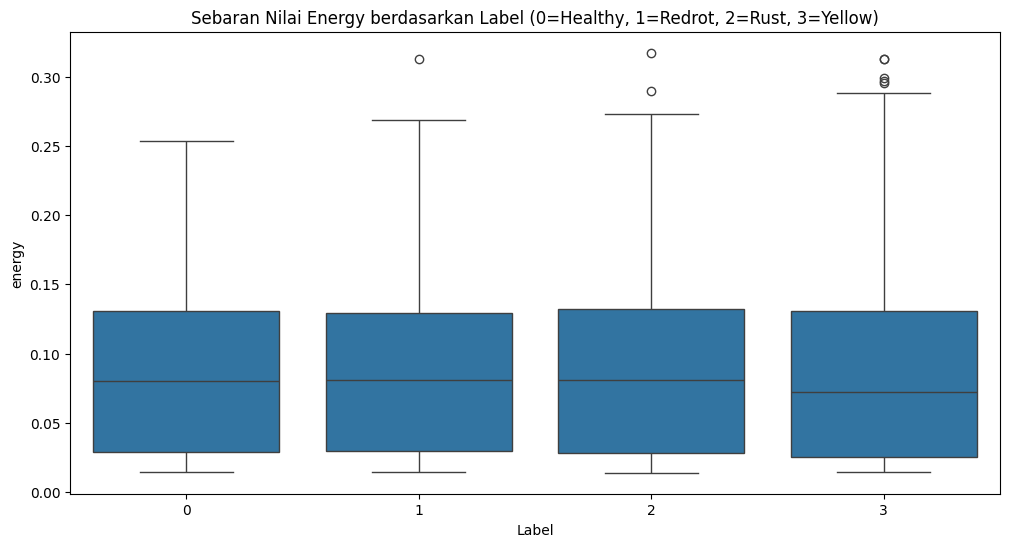

In [21]:
# Visualisasi sebaran fitur GLCM contrast
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='energy', data=df)
plt.title('Sebaran Nilai Energy berdasarkan Label (0=Healthy, 1=Redrot, 2=Rust, 3=Yellow)')
plt.xlabel('Label')
plt.show()


In [22]:
import pandas as pd

# Muat kembali data csv yang telah diunggah sebelumnya
df = pd.read_csv("/content/glcm_tebu.csv")

# Ambil hanya kolom yang dibutuhkan
selected_columns = df[['label', 'energy', 'homogeneity', 'entropy']]

# Simpan ke dalam file Excel
excel_path = "/content/boxplot_data_glcm.xlsx"
selected_columns.to_excel(excel_path, index=False)

excel_path


'/content/boxplot_data_glcm.xlsx'

## Hyperparameter Tuning

Nilai K terbaik berdasarkan cross-validation: 1

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       223
           1       0.63      0.62      0.63       223
           2       0.58      0.62      0.60       222
           3       0.67      0.71      0.69       190

    accuracy                           0.64       858
   macro avg       0.64      0.64      0.64       858
weighted avg       0.64      0.64      0.64       858



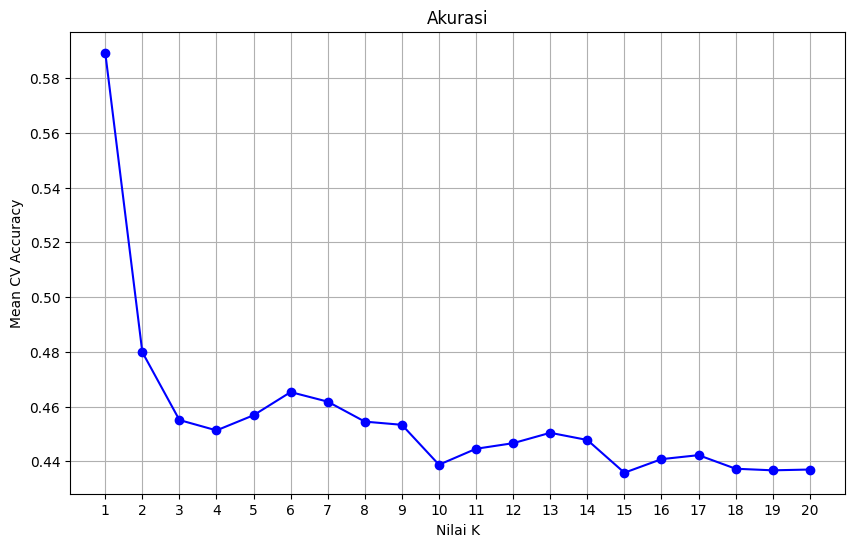

In [23]:
# Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

# 1. Load CSV hasil ekstraksi fitur GLCM
df = pd.read_csv('/content/glcm_tebu.csv')

# 2. Pisahkan fitur dan label
X = df.drop(columns=['label', 'filename'])  # Hapus kolom yang bukan fitur
y = df['label']  # Label: 0 = Healthy, 1 = redrot, 2 = rust, 3 = yellow

# 3. Split data latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 4. Normalisasi fitur
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5. KNN Cross Validation (1–20)
k_values = list(range(1, 21))
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_scaled, y_train, cv=5)
    mean_scores.append(scores.mean())

# 6. Visualisasi akurasi berdasarkan nilai K
plt.figure(figsize=(10, 6))
plt.plot(k_values, mean_scores, marker='o', linestyle='-', color='blue')
plt.title('Akurasi')
plt.xlabel('Nilai K')
plt.ylabel('Mean CV Accuracy')
plt.xticks(k_values)
plt.grid(True)

# 7. Gunakan K terbaik (misalnya K = 5, atau yang tertinggi dari chart)
best_k = k_values[np.argmax(mean_scores)]
print(f"Nilai K terbaik berdasarkan cross-validation: {best_k}")

# 8. Latih model akhir dengan K terbaik
knn_final = KNeighborsClassifier(n_neighbors=best_k)
knn_final.fit(X_train_scaled, y_train)

# 9. Evaluasi model
y_pred = knn_final.predict(X_test_scaled)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Nilai K Terbaik = 1

## CV Data Testing

Confusion Matrix:
[[138  36  36  13]
 [ 24 139  37  23]
 [ 23  30 138  31]
 [ 12  16  28 134]]

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       223
           1       0.63      0.62      0.63       223
           2       0.58      0.62      0.60       222
           3       0.67      0.71      0.69       190

    accuracy                           0.64       858
   macro avg       0.64      0.64      0.64       858
weighted avg       0.64      0.64      0.64       858


Akurasi: 0.6399


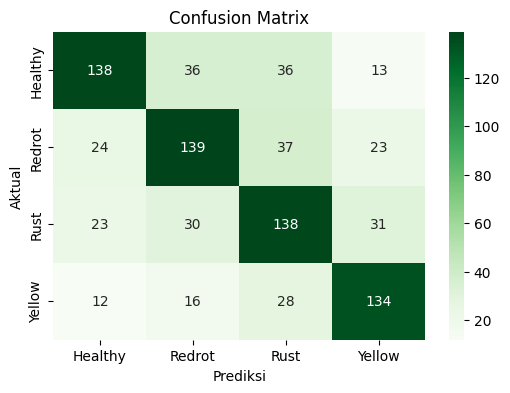

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Inisialisasi model dengan k = 1
knn = KNeighborsClassifier(n_neighbors=1)

# Latih model
knn.fit(X_train_scaled, y_train)

# Prediksi data test
y_pred = knn.predict(X_test_scaled)

# Evaluasi performa
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nAkurasi: {accuracy_score(y_test, y_pred):.4f}")

# Visualisasi confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Greens', xticklabels=["Healthy", "Redrot", "Rust", "Yellow"], yticklabels=["Healthy", "Redrot", "Rust", "Yellow"])
plt.xlabel("Prediksi")
plt.ylabel("Aktual")
plt.title("Confusion Matrix")
plt.show()


In [25]:
import pandas as pd

# Muat data
df = pd.read_csv("/content/glcm_tebu.csv")

# Buat dictionary untuk label ke nama kelas
label_map = {
    0: 'healthy',
    1: 'redrot',
    2: 'rust',
    3: 'yellow'
}

# Tambahkan kolom nama kelas berdasarkan label
df['class'] = df['label'].map(label_map)

# Buat file Excel dengan sheet berbeda untuk setiap fitur
excel_path = "/content/boxplot_data_glcm_by_class.xlsx"
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for feature in ['energy', 'entropy', 'homogeneity']:
        # Pivot data: baris = class, kolom = nilai fitur
        grouped = df[['class', feature]].copy()
        grouped.to_excel(writer, sheet_name=feature, index=False)

excel_path


'/content/boxplot_data_glcm_by_class.xlsx'

In [26]:
import pandas as pd

# Muat data
df = pd.read_csv("/content/glcm_tebu.csv")

# Pemetaan label ke nama kelas
label_map = {
    0: 'healthy',
    1: 'redrot',
    2: 'rust',
    3: 'yellow'
}

df['class'] = df['label'].map(label_map)

# Path file Excel
excel_path = "/content/boxplot_data_glcm_pivot.xlsx"

# Buat file Excel dengan sheet terpisah dan kolom kelas
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    for feature in ['energy', 'entropy', 'homogeneity']:
        # Buat pivot: satu kolom untuk setiap kelas
        pivot = df.pivot(columns='class', values=feature)
        pivot.to_excel(writer, sheet_name=feature, index=False)

excel_path


'/content/boxplot_data_glcm_pivot.xlsx'

In [27]:
import pandas as pd

# Muat data
df = pd.read_csv("/content/glcm_tebu.csv")

# Pemetaan label ke nama kelas
label_map = {
    0: 'healthy',
    1: 'redrot',
    2: 'rust',
    3: 'yellow'
}

df['class'] = df['label'].map(label_map)

# Buat dictionary untuk menyimpan nilai tiap kelas
class_values = {}

# Ambil salah satu fitur, misal 'entropy'
feature = 'entropy'  # ganti sesuai kebutuhan (bisa 'energy', 'homogeneity', dll)

# Ambil data untuk tiap kelas
for cls in ['healthy', 'redrot', 'rust', 'yellow']:
    values = df[df['class'] == cls][feature].tolist()
    class_values[cls] = values

# Tentukan panjang terpendek
min_len = min(len(v) for v in class_values.values())

# Potong semua data agar panjangnya sama
for cls in class_values:
    class_values[cls] = class_values[cls][:min_len]

# Buat dataframe dari dictionary
equal_df = pd.DataFrame(class_values)

# Simpan ke Excel
output_path = "/content/boxplot_4class_no_nan.xlsx"
equal_df.to_excel(output_path, index=False)

output_path


'/content/boxplot_4class_no_nan.xlsx'

In [28]:
model.save('knn_sugarcane_disease_prediction_model.h5')